In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import numpy as np

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop,SGD

from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.layers import Dense, Input, Dropout, Activation, Conv2D, MaxPooling2D, Lambda, Flatten, GlobalAveragePooling2D
from keras.layers.merge import concatenate

from keras.applications.vgg16 import VGG16
from keras.applications.mobilenet import MobileNet
from keras.applications.resnet50 import ResNet50

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data-ISBI-resized/train/'
validation_dir = 'data-ISBI-resized/validation/'
test_dir = 'data-ISBI-resized/test/'

extracted_features_dir = "extracted_features/"
model_name = "VGG16_MobileNet_Concatenate3_ImageNetMean_SGD"

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data-ISBI-resized/train/ 0
data-ISBI-resized/train/malignant 40425
data-ISBI-resized/train/normal 18747
******************************
data-ISBI-resized/test/ 0
data-ISBI-resized/test/malignant 655
data-ISBI-resized/test/normal 312


In [5]:
batch_size = 32
img_height, img_width = 380, 380
input_shape = (img_height, img_width, 3)
epochs = 1000

top_model_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_model.h5')
top_model_weights_path = os.path.join(extracted_features_dir, 'model_'+model_name+'_weights.h5')

In [6]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=False,
    featurewise_std_normalization=False,
#     validation_split= 0.25,
    preprocessing_function = preprocess_input,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
#     subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 59170 images belonging to 2 classes.
Found 18384 images belonging to 2 classes.
Found 967 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 59170
nb_validation_samples: 18384
nb_test_samples: 967

predict_size_train: 1850
predict_size_validation: 575
predict_size_test: 31

 num_classes: 2


In [9]:
basemodel1=VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
x1=basemodel1.get_layer('block5_pool').output
x1=GlobalAveragePooling2D()(x1)

basemodel2=MobileNet(weights=None,input_tensor = basemodel1.input, include_top=False, input_shape=input_shape)
x2 = basemodel2.output
x2 = GlobalAveragePooling2D()(x2)

merge = concatenate([x1, x2])
merge = Dropout(0.6)(merge)
preds = Dense(num_classes, activation='relu')(merge)
model = Model(inputs=basemodel1.input,outputs=preds)

In [10]:
# bottleneck_final_model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

In [11]:
c1 = model.layers[74].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[80].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[88].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[96].output
c4 = GlobalAveragePooling2D()(c4)

c5 = model.layers[103].output
c5 = GlobalAveragePooling2D()(c5)


con = concatenate([c1,c2,c3,c4,c5])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [12]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [13]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [14]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [15]:
import tensorflow as tf
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

sgd_opt=SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False)
model.compile(optimizer=sgd_opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

model.save_weights(top_model_weights_path)
model.save(top_model_path)

Train on 59170 samples, validate on 18384 samples
Epoch 1/1000
 - 7s - loss: 0.6179 - acc: 0.6827 - val_loss: 0.6050 - val_acc: 0.6806
Epoch 2/1000
 - 6s - loss: 0.5976 - acc: 0.6833 - val_loss: 0.5885 - val_acc: 0.6806
Epoch 3/1000
 - 6s - loss: 0.5822 - acc: 0.6854 - val_loss: 0.5738 - val_acc: 0.6806
Epoch 4/1000
 - 6s - loss: 0.5674 - acc: 0.6972 - val_loss: 0.5584 - val_acc: 0.7055
Epoch 5/1000
 - 6s - loss: 0.5538 - acc: 0.7190 - val_loss: 0.5477 - val_acc: 0.7090
Epoch 6/1000
 - 6s - loss: 0.5428 - acc: 0.7388 - val_loss: 0.5360 - val_acc: 0.7369
Epoch 7/1000
 - 6s - loss: 0.5343 - acc: 0.7514 - val_loss: 0.5264 - val_acc: 0.7639
Epoch 8/1000
 - 6s - loss: 0.5265 - acc: 0.7594 - val_loss: 0.5215 - val_acc: 0.7585
Epoch 9/1000
 - 6s - loss: 0.5215 - acc: 0.7649 - val_loss: 0.5165 - val_acc: 0.7648
Epoch 10/1000
 - 6s - loss: 0.5176 - acc: 0.7678 - val_loss: 0.5114 - val_acc: 0.7744
Epoch 11/1000
 - 6s - loss: 0.5142 - acc: 0.7704 - val_loss: 0.5088 - val_acc: 0.7728
Epoch 12/1000

Epoch 96/1000
 - 6s - loss: 0.4818 - acc: 0.7848 - val_loss: 0.4793 - val_acc: 0.7858
Epoch 97/1000
 - 6s - loss: 0.4820 - acc: 0.7856 - val_loss: 0.4797 - val_acc: 0.7847
Epoch 98/1000
 - 6s - loss: 0.4819 - acc: 0.7848 - val_loss: 0.4851 - val_acc: 0.7829
Epoch 99/1000
 - 6s - loss: 0.4811 - acc: 0.7856 - val_loss: 0.4849 - val_acc: 0.7835
Epoch 100/1000
 - 6s - loss: 0.4815 - acc: 0.7860 - val_loss: 0.4803 - val_acc: 0.7864
Epoch 101/1000
 - 6s - loss: 0.4810 - acc: 0.7859 - val_loss: 0.4776 - val_acc: 0.7868
Epoch 102/1000
 - 6s - loss: 0.4809 - acc: 0.7855 - val_loss: 0.4778 - val_acc: 0.7870
Epoch 103/1000
 - 6s - loss: 0.4804 - acc: 0.7864 - val_loss: 0.4773 - val_acc: 0.7868
Epoch 104/1000
 - 6s - loss: 0.4796 - acc: 0.7858 - val_loss: 0.4775 - val_acc: 0.7861
Epoch 105/1000
 - 6s - loss: 0.4802 - acc: 0.7864 - val_loss: 0.4769 - val_acc: 0.7868
Epoch 106/1000
 - 6s - loss: 0.4803 - acc: 0.7856 - val_loss: 0.4823 - val_acc: 0.7855
Epoch 107/1000
 - 6s - loss: 0.4796 - acc: 0.78

Epoch 191/1000
 - 6s - loss: 0.4645 - acc: 0.7945 - val_loss: 0.4636 - val_acc: 0.7949
Epoch 192/1000
 - 6s - loss: 0.4645 - acc: 0.7939 - val_loss: 0.4606 - val_acc: 0.7975
Epoch 193/1000
 - 6s - loss: 0.4647 - acc: 0.7946 - val_loss: 0.4672 - val_acc: 0.7972
Epoch 194/1000
 - 6s - loss: 0.4641 - acc: 0.7951 - val_loss: 0.4623 - val_acc: 0.7951
Epoch 195/1000
 - 6s - loss: 0.4635 - acc: 0.7944 - val_loss: 0.4618 - val_acc: 0.7975
Epoch 196/1000
 - 6s - loss: 0.4638 - acc: 0.7929 - val_loss: 0.4599 - val_acc: 0.7979
Epoch 197/1000
 - 6s - loss: 0.4634 - acc: 0.7959 - val_loss: 0.4612 - val_acc: 0.7981
Epoch 198/1000
 - 6s - loss: 0.4632 - acc: 0.7945 - val_loss: 0.4594 - val_acc: 0.7987
Epoch 199/1000
 - 6s - loss: 0.4631 - acc: 0.7947 - val_loss: 0.4625 - val_acc: 0.7955
Epoch 200/1000
 - 6s - loss: 0.4632 - acc: 0.7952 - val_loss: 0.4593 - val_acc: 0.7975
Epoch 201/1000
 - 6s - loss: 0.4628 - acc: 0.7955 - val_loss: 0.4662 - val_acc: 0.7948
Epoch 202/1000
 - 6s - loss: 0.4628 - acc: 

 - 6s - loss: 0.4534 - acc: 0.8010 - val_loss: 0.4515 - val_acc: 0.8034
Epoch 286/1000
 - 6s - loss: 0.4526 - acc: 0.8010 - val_loss: 0.4527 - val_acc: 0.8013
Epoch 287/1000
 - 6s - loss: 0.4528 - acc: 0.8008 - val_loss: 0.4493 - val_acc: 0.8041
Epoch 288/1000
 - 6s - loss: 0.4534 - acc: 0.8015 - val_loss: 0.4660 - val_acc: 0.7980
Epoch 289/1000
 - 6s - loss: 0.4525 - acc: 0.8009 - val_loss: 0.4535 - val_acc: 0.8016
Epoch 290/1000
 - 6s - loss: 0.4526 - acc: 0.8012 - val_loss: 0.4512 - val_acc: 0.8034
Epoch 291/1000
 - 6s - loss: 0.4529 - acc: 0.8008 - val_loss: 0.4558 - val_acc: 0.7988
Epoch 292/1000
 - 6s - loss: 0.4526 - acc: 0.8001 - val_loss: 0.4492 - val_acc: 0.8045
Epoch 293/1000
 - 6s - loss: 0.4524 - acc: 0.8012 - val_loss: 0.4521 - val_acc: 0.8003
Epoch 294/1000
 - 6s - loss: 0.4523 - acc: 0.8006 - val_loss: 0.4548 - val_acc: 0.7996
Epoch 295/1000
 - 6s - loss: 0.4521 - acc: 0.8009 - val_loss: 0.4518 - val_acc: 0.8042
Epoch 296/1000
 - 6s - loss: 0.4517 - acc: 0.8014 - val_lo

Epoch 380/1000
 - 6s - loss: 0.4458 - acc: 0.8057 - val_loss: 0.4458 - val_acc: 0.8051
Epoch 381/1000
 - 6s - loss: 0.4467 - acc: 0.8046 - val_loss: 0.4482 - val_acc: 0.8041
Epoch 382/1000
 - 6s - loss: 0.4453 - acc: 0.8047 - val_loss: 0.4458 - val_acc: 0.8033
Epoch 383/1000
 - 6s - loss: 0.4462 - acc: 0.8052 - val_loss: 0.4469 - val_acc: 0.8068
Epoch 384/1000
 - 6s - loss: 0.4455 - acc: 0.8045 - val_loss: 0.4444 - val_acc: 0.8078
Epoch 385/1000
 - 6s - loss: 0.4456 - acc: 0.8046 - val_loss: 0.4478 - val_acc: 0.8026
Epoch 386/1000
 - 6s - loss: 0.4457 - acc: 0.8054 - val_loss: 0.4462 - val_acc: 0.8025
Epoch 387/1000
 - 6s - loss: 0.4459 - acc: 0.8049 - val_loss: 0.4544 - val_acc: 0.8052
Epoch 388/1000
 - 6s - loss: 0.4460 - acc: 0.8042 - val_loss: 0.4447 - val_acc: 0.8085
Epoch 389/1000
 - 6s - loss: 0.4447 - acc: 0.8052 - val_loss: 0.4478 - val_acc: 0.8054
Epoch 390/1000
 - 6s - loss: 0.4453 - acc: 0.8049 - val_loss: 0.4483 - val_acc: 0.8072
Epoch 391/1000
 - 6s - loss: 0.4454 - acc: 

 - 6s - loss: 0.4410 - acc: 0.8065 - val_loss: 0.4414 - val_acc: 0.8071
Epoch 475/1000
 - 6s - loss: 0.4403 - acc: 0.8073 - val_loss: 0.4501 - val_acc: 0.8024
Epoch 476/1000
 - 6s - loss: 0.4402 - acc: 0.8081 - val_loss: 0.4415 - val_acc: 0.8073
Epoch 477/1000
 - 6s - loss: 0.4402 - acc: 0.8083 - val_loss: 0.4400 - val_acc: 0.8115
Epoch 478/1000
 - 6s - loss: 0.4397 - acc: 0.8071 - val_loss: 0.4417 - val_acc: 0.8092
Epoch 479/1000
 - 6s - loss: 0.4392 - acc: 0.8080 - val_loss: 0.4416 - val_acc: 0.8122
Epoch 480/1000
 - 6s - loss: 0.4393 - acc: 0.8094 - val_loss: 0.4427 - val_acc: 0.8105
Epoch 481/1000
 - 6s - loss: 0.4394 - acc: 0.8076 - val_loss: 0.4390 - val_acc: 0.8114
Epoch 482/1000
 - 6s - loss: 0.4388 - acc: 0.8085 - val_loss: 0.4387 - val_acc: 0.8116
Epoch 483/1000
 - 6s - loss: 0.4395 - acc: 0.8091 - val_loss: 0.4458 - val_acc: 0.8046
Epoch 484/1000
 - 6s - loss: 0.4393 - acc: 0.8082 - val_loss: 0.4409 - val_acc: 0.8064
Epoch 485/1000
 - 6s - loss: 0.4390 - acc: 0.8084 - val_lo

Epoch 569/1000
 - 6s - loss: 0.4358 - acc: 0.8103 - val_loss: 0.4352 - val_acc: 0.8141
Epoch 570/1000
 - 6s - loss: 0.4346 - acc: 0.8107 - val_loss: 0.4424 - val_acc: 0.8099
Epoch 571/1000
 - 6s - loss: 0.4347 - acc: 0.8097 - val_loss: 0.4369 - val_acc: 0.8105
Epoch 572/1000
 - 6s - loss: 0.4354 - acc: 0.8094 - val_loss: 0.4397 - val_acc: 0.8136
Epoch 573/1000
 - 6s - loss: 0.4340 - acc: 0.8116 - val_loss: 0.4405 - val_acc: 0.8059
Epoch 574/1000
 - 6s - loss: 0.4350 - acc: 0.8112 - val_loss: 0.4399 - val_acc: 0.8090
Epoch 575/1000
 - 6s - loss: 0.4345 - acc: 0.8113 - val_loss: 0.4356 - val_acc: 0.8132
Epoch 576/1000
 - 6s - loss: 0.4354 - acc: 0.8107 - val_loss: 0.4426 - val_acc: 0.8107
Epoch 577/1000
 - 6s - loss: 0.4349 - acc: 0.8115 - val_loss: 0.4368 - val_acc: 0.8089
Epoch 578/1000
 - 6s - loss: 0.4346 - acc: 0.8106 - val_loss: 0.4441 - val_acc: 0.8101
Epoch 579/1000
 - 6s - loss: 0.4343 - acc: 0.8114 - val_loss: 0.4341 - val_acc: 0.8130
Epoch 580/1000
 - 6s - loss: 0.4348 - acc: 

 - 6s - loss: 0.4304 - acc: 0.8146 - val_loss: 0.4310 - val_acc: 0.8164
Epoch 664/1000
 - 6s - loss: 0.4301 - acc: 0.8133 - val_loss: 0.4325 - val_acc: 0.8147
Epoch 665/1000
 - 6s - loss: 0.4314 - acc: 0.8127 - val_loss: 0.4425 - val_acc: 0.8054
Epoch 666/1000
 - 6s - loss: 0.4312 - acc: 0.8125 - val_loss: 0.4347 - val_acc: 0.8110
Epoch 667/1000
 - 6s - loss: 0.4315 - acc: 0.8128 - val_loss: 0.4320 - val_acc: 0.8160
Epoch 668/1000
 - 6s - loss: 0.4297 - acc: 0.8140 - val_loss: 0.4329 - val_acc: 0.8139
Epoch 669/1000
 - 6s - loss: 0.4298 - acc: 0.8122 - val_loss: 0.4360 - val_acc: 0.8112
Epoch 670/1000
 - 6s - loss: 0.4302 - acc: 0.8132 - val_loss: 0.4315 - val_acc: 0.8159
Epoch 671/1000
 - 6s - loss: 0.4302 - acc: 0.8133 - val_loss: 0.4392 - val_acc: 0.8068
Epoch 672/1000
 - 6s - loss: 0.4310 - acc: 0.8117 - val_loss: 0.4322 - val_acc: 0.8145
Epoch 673/1000
 - 6s - loss: 0.4304 - acc: 0.8123 - val_loss: 0.4407 - val_acc: 0.8097
Epoch 674/1000
 - 6s - loss: 0.4300 - acc: 0.8142 - val_lo

Epoch 758/1000
 - 6s - loss: 0.4266 - acc: 0.8156 - val_loss: 0.4290 - val_acc: 0.8158
Epoch 759/1000
 - 6s - loss: 0.4261 - acc: 0.8155 - val_loss: 0.4307 - val_acc: 0.8164
Epoch 760/1000
 - 6s - loss: 0.4269 - acc: 0.8147 - val_loss: 0.4376 - val_acc: 0.8094
Epoch 761/1000
 - 6s - loss: 0.4273 - acc: 0.8149 - val_loss: 0.4315 - val_acc: 0.8179
Epoch 762/1000
 - 6s - loss: 0.4264 - acc: 0.8158 - val_loss: 0.4282 - val_acc: 0.8147
Epoch 763/1000
 - 6s - loss: 0.4273 - acc: 0.8158 - val_loss: 0.4276 - val_acc: 0.8171
Epoch 764/1000
 - 6s - loss: 0.4267 - acc: 0.8158 - val_loss: 0.4343 - val_acc: 0.8113
Epoch 765/1000
 - 6s - loss: 0.4263 - acc: 0.8139 - val_loss: 0.4488 - val_acc: 0.8058
Epoch 766/1000
 - 6s - loss: 0.4264 - acc: 0.8162 - val_loss: 0.4347 - val_acc: 0.8152
Epoch 767/1000
 - 6s - loss: 0.4268 - acc: 0.8150 - val_loss: 0.4307 - val_acc: 0.8160
Epoch 768/1000
 - 6s - loss: 0.4272 - acc: 0.8151 - val_loss: 0.4289 - val_acc: 0.8178
Epoch 769/1000
 - 6s - loss: 0.4255 - acc: 

 - 6s - loss: 0.4237 - acc: 0.8167 - val_loss: 0.4274 - val_acc: 0.8164
Epoch 853/1000
 - 6s - loss: 0.4241 - acc: 0.8168 - val_loss: 0.4309 - val_acc: 0.8175
Epoch 854/1000
 - 6s - loss: 0.4239 - acc: 0.8162 - val_loss: 0.4293 - val_acc: 0.8156
Epoch 855/1000
 - 6s - loss: 0.4233 - acc: 0.8173 - val_loss: 0.4300 - val_acc: 0.8146
Epoch 856/1000
 - 6s - loss: 0.4252 - acc: 0.8154 - val_loss: 0.4251 - val_acc: 0.8189
Epoch 857/1000
 - 6s - loss: 0.4241 - acc: 0.8161 - val_loss: 0.4487 - val_acc: 0.7997
Epoch 858/1000
 - 6s - loss: 0.4235 - acc: 0.8153 - val_loss: 0.4316 - val_acc: 0.8168
Epoch 859/1000
 - 6s - loss: 0.4244 - acc: 0.8153 - val_loss: 0.4254 - val_acc: 0.8192
Epoch 860/1000
 - 6s - loss: 0.4231 - acc: 0.8158 - val_loss: 0.4290 - val_acc: 0.8155
Epoch 861/1000
 - 6s - loss: 0.4240 - acc: 0.8164 - val_loss: 0.4246 - val_acc: 0.8187
Epoch 862/1000
 - 6s - loss: 0.4244 - acc: 0.8158 - val_loss: 0.4283 - val_acc: 0.8191
Epoch 863/1000
 - 6s - loss: 0.4243 - acc: 0.8162 - val_lo

Epoch 947/1000
 - 6s - loss: 0.4206 - acc: 0.8173 - val_loss: 0.4231 - val_acc: 0.8188
Epoch 948/1000
 - 6s - loss: 0.4204 - acc: 0.8186 - val_loss: 0.4253 - val_acc: 0.8167
Epoch 949/1000
 - 6s - loss: 0.4210 - acc: 0.8178 - val_loss: 0.4261 - val_acc: 0.8160
Epoch 950/1000
 - 6s - loss: 0.4202 - acc: 0.8193 - val_loss: 0.4293 - val_acc: 0.8167
Epoch 951/1000
 - 6s - loss: 0.4209 - acc: 0.8183 - val_loss: 0.4443 - val_acc: 0.8123
Epoch 952/1000
 - 6s - loss: 0.4194 - acc: 0.8176 - val_loss: 0.4231 - val_acc: 0.8188
Epoch 953/1000
 - 6s - loss: 0.4206 - acc: 0.8175 - val_loss: 0.4269 - val_acc: 0.8202
Epoch 954/1000
 - 6s - loss: 0.4203 - acc: 0.8185 - val_loss: 0.4309 - val_acc: 0.8121
Epoch 955/1000
 - 6s - loss: 0.4200 - acc: 0.8195 - val_loss: 0.4243 - val_acc: 0.8218
Epoch 956/1000
 - 6s - loss: 0.4204 - acc: 0.8178 - val_loss: 0.4257 - val_acc: 0.8167
Epoch 957/1000
 - 6s - loss: 0.4217 - acc: 0.8167 - val_loss: 0.4284 - val_acc: 0.8183
Epoch 958/1000
 - 6s - loss: 0.4207 - acc: 

In [18]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

18384/18384 [==============================] - 1s 40us/step
Validation Accuracy: 81.9952%
Validation Loss: 0.4219936256931594


In [19]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9317476732161324


Confusion Matrix
[[651   4]
 [ 62 250]]


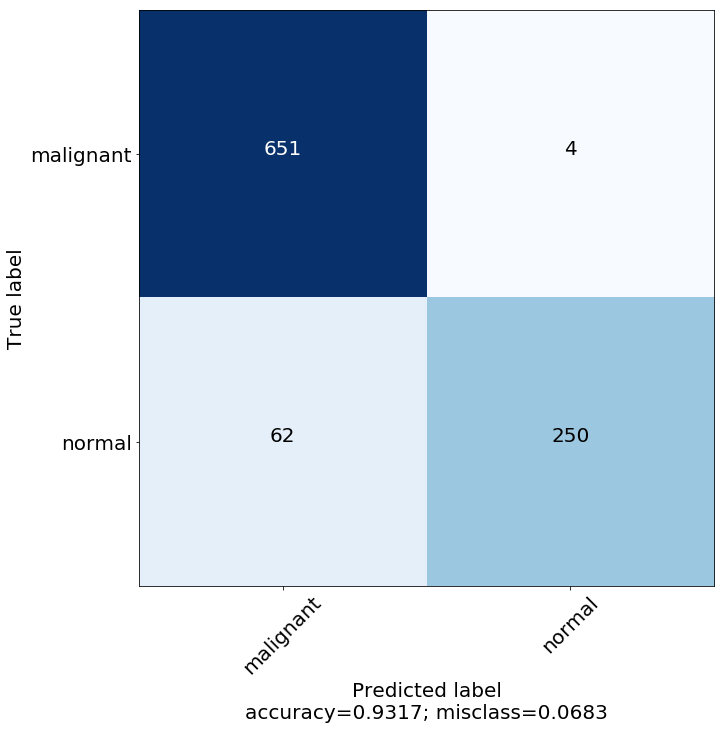

In [20]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[651   4]
 [ 62 250]]
              precision    recall  f1-score   support

   malignant       0.91      0.99      0.95       655
      normal       0.98      0.80      0.88       312

   micro avg       0.93      0.93      0.93       967
   macro avg       0.95      0.90      0.92       967
weighted avg       0.94      0.93      0.93       967



In [22]:
total=sum(sum(cm))

# accuracy = (cm[0,0]+cm[1,1]) / total
# print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  91.30434782608695
Specificity :  98.4251968503937


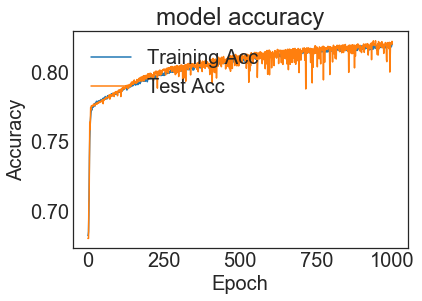

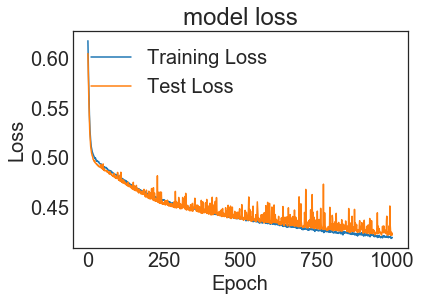

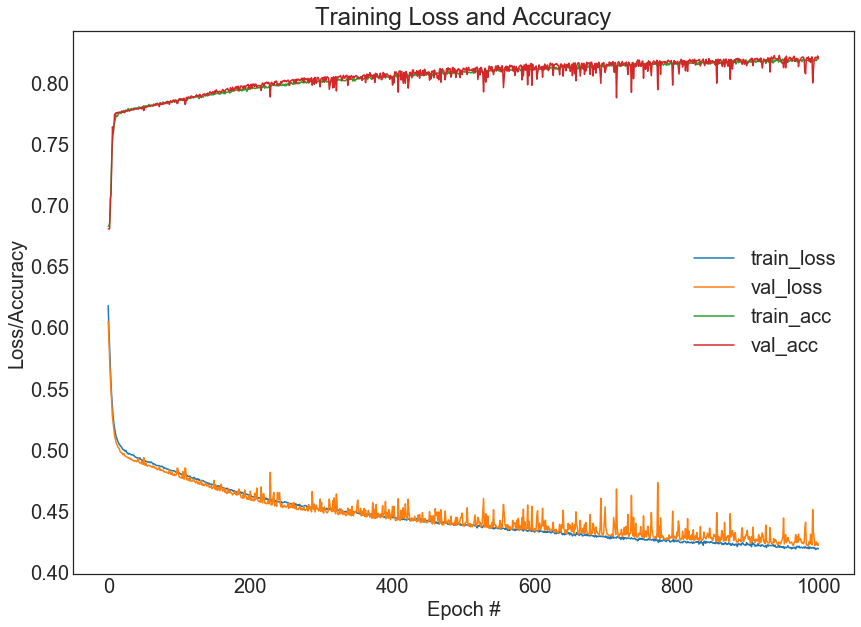

In [23]:
import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure(figsize=(14,10))
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")

In [24]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

967/967 [==============================] - 0s 50us/step
Precision =  0.93601870985946
Recall =  0.9317476732161324
f1_score =  0.9296975153726179


In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.8975875905265217


In [26]:
sample_count = test_generator.samples
print('Sample count: {}'.format(sample_count))

fnames = test_generator.filenames
ground_truth = test_generator.classes
label2index = test_generator.class_indices
# Getting the mapping from class index to class label
idx2label = dict((v, k) for k, v in label2index.items())
predictions = model.predict_classes(test_data)
prob = model.predict(test_data)
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), sample_count))

Sample count: 967
No of errors = 66/967
